# Data Exploration

This notebook will primarily explore the dataset, and using insights gained from the EDA, experiment with preprocessing steps.


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split


In [96]:
def summarise_df(df: pd.DataFrame):
    print(f"Shape: {df.shape}")
    print("\nColumn types:\n", df.dtypes.value_counts())
    print(f"\nConstant columns:\n{df.nunique()[df.nunique() <= 1]}\n")
    df.info(verbose=True, show_counts=True, max_cols=None)
    print(df.describe(include='all'))

def print_unique_values(df: pd.DataFrame):
    for col in df.columns:
        if col == 'Attack_label' or col == 'Attack_type':
            continue
        if len(df[col].value_counts()) > 10:
            continue
        print("Unique values of ", col, ":", df[col].value_counts())

def show_target_distribution(df: pd.DataFrame):
    sns.countplot(data=df, x='Attack_label')
    plt.title("Binary Attack Label Distribution")
    plt.tight_layout()
    plt.show()
    print(df['Attack_label'].value_counts())


def plot_correlation_heatmap(df: pd.DataFrame, threshold: float = 0.9):
    corr = df.select_dtypes(include='number').corr()
    # Identify highly correlated pairs
    high_corr = ((corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
                  .stack()
                  .reset_index()
                  .rename(columns={0: 'correlation'}))
                 .query('abs(correlation) > @threshold'))
    print("Highly correlated features (>|0.9|):\n", high_corr)

    # plot
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Feature Correlation Heatmap")
    plt.show()


In [97]:
path = "./dataset/edge-iiotset/"

normal_path = path + ("normal/")
attack_path = path + ("attack/")
eval_path = "./dataset/edge-iiotset/eval/"
# output_path = "./dataset/edge-iiotset/eda_output/"


## Read, Load, Examine


Highly correlated features (>|0.9|):
                     level_0         level_1  correlation
0                arp.opcode     arp.hw.size     0.944180
405               tcp.flags   tcp.flags.ack     0.949096
559  mqtt.conflag.cleansess   mqtt.conflags     1.000000
563  mqtt.conflag.cleansess  mqtt.proto_len     1.000000
565  mqtt.conflag.cleansess        mqtt.ver     1.000000
570           mqtt.conflags  mqtt.proto_len     1.000000
572           mqtt.conflags        mqtt.ver     1.000000
575           mqtt.hdrflags    mqtt.msgtype     1.000000
582                mqtt.len  mqtt.topic_len     0.954335
590          mqtt.proto_len        mqtt.ver     1.000000


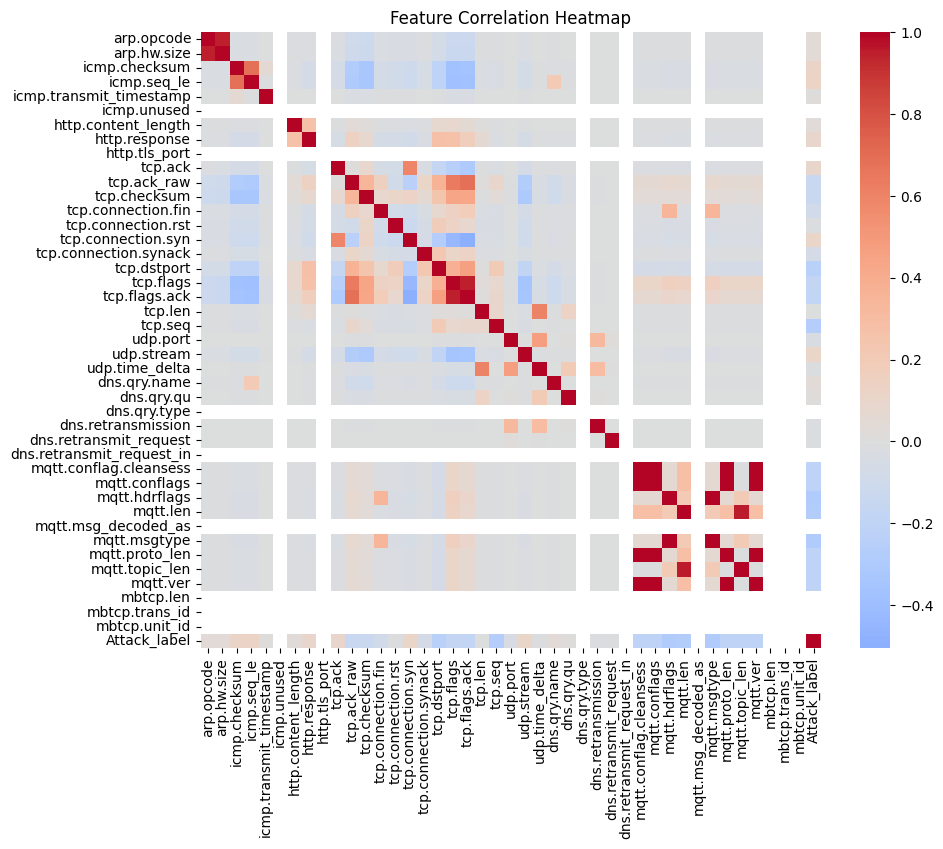

Shape: (157800, 63)

Column types:
 float64    42
object     20
int64       1
Name: count, dtype: int64

Constant columns:
icmp.unused                  1
http.tls_port                1
dns.qry.type                 1
dns.retransmit_request_in    1
mqtt.msg_decoded_as          1
mbtcp.len                    1
mbtcp.trans_id               1
mbtcp.unit_id                1
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 63 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   frame.time                 157800 non-null  object 
 1   ip.src_host                157800 non-null  object 
 2   ip.dst_host                157800 non-null  object 
 3   arp.dst.proto_ipv4         157800 non-null  object 
 4   arp.opcode                 157800 non-null  float64
 5   arp.hw.size                157800 non-null  float64
 6   arp.src.proto_ipv4         157800 non-null 

In [125]:
# df = pd.read_csv(eval_path+'DNN-EdgeIIoT-dataset.csv', encoding='utf-8', low_memory=False)
df = pd.read_csv(eval_path+'ML-EdgeIIoT-dataset.csv', encoding='utf-8', low_memory=False)

# visualise_df(df)
plot_correlation_heatmap(df)

summarise_df(df)

print_unique_values(df)


## Global Preprocessing 

Dropping irrelevant columns, removing duplicate rows

### Data Cleaning


In [126]:
df = df.drop_duplicates()


### Safe Columns to Drop


In [116]:
drop_cols = [
    # true constant across dataset
    "icmp.unused",
    
    # domain specific
    "frame.time",
    "ip.src_host",
    "ip.dst_host",
    "arp.src.proto_ipv4",
    "arp.dst.proto_ipv4",
    "http.file_data",
    "http.request.full_uri",
    "icmp.transmit_timestamp",
    
    # highly correlated
    "arp.hw.size",
    "tcp.flags",
    "dns.retransmit_request_in",
    "mqtt.conflags",
    "mqtt.proto_len",
    "mqtt.ver",
    "mqtt.hdrflags",
    "mqtt.len",
    "mbtcp.len",
    "Attack_type"
]


### Constant & Sparse Columns


In [101]:
from collections import defaultdict

constant_columns = [col for col in df.columns if df[col].nunique() == 1]

print(f"Constant columns: {constant_columns}")

sparse_columns = [col for col in df.columns if col not in constant_columns and col !="Attack_label" and df[col].eq(0).sum() >= 0.99]

print(f"Sparse columns: {sparse_columns}")


Constant columns: ['http.tls_port', 'dns.qry.type', 'mqtt.msg_decoded_as', 'mbtcp.trans_id', 'mbtcp.unit_id']
Sparse columns: ['arp.opcode', 'icmp.checksum', 'icmp.seq_le', 'http.content_length', 'http.response', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.dstport', 'tcp.flags.ack', 'tcp.len', 'tcp.seq', 'udp.port', 'udp.stream', 'udp.time_delta', 'dns.qry.name', 'dns.qry.qu', 'dns.retransmission', 'dns.retransmit_request', 'mqtt.conflag.cleansess', 'mqtt.msgtype', 'mqtt.topic_len']


In [109]:
all_columns = {
    'constant': constant_columns,
    'sparse': sparse_columns
}
all_cols_set = list(set(constant_columns + sparse_columns))

stats = {
    key: {
        'zero_counts': defaultdict(int),
        'non_zero_counts': defaultdict(int),
        'value_counts': {col: defaultdict(int) for col in cols}
    }
    for key, cols in all_columns.items()
}

total_rows = 0

# Process files
for path in [normal_path, attack_path]:
    for file in os.listdir(path):
        if file.endswith(".csv"):
            file_path = os.path.join(path, file)
            df = pd.read_csv(file_path, usecols=all_cols_set,
                             encoding='utf-8', low_memory=False)
            total_rows += len(df)
            for key, cols in all_columns.items():
                for col in cols:
                    stats[key]['zero_counts'][col] += (df[col] == 0).sum()
                    stats[key]['non_zero_counts'][col] += (df[col] != 0).sum()
                    for val, count in df[col].value_counts(dropna=True).items():
                        stats[key]['value_counts'][col][val] += count


In [110]:
for key in all_columns:
    print(f"\n--- {key.upper()} FEATURES ---")
    for col in all_columns[key]:
        zero = stats[key]['zero_counts'][col]
        non_zero = stats[key]['non_zero_counts'][col]
        values = stats[key]['value_counts'][col]

        total_unique = len(values)
        sparsity = zero / total_rows
        dominant_ratio = max(values.values()) / (zero + non_zero)

        print(f"{col} — Unique values: {total_unique}, "
              f"0-based sparsity: {sparsity:.8%} of {total_rows}, "
              f"Dominant ratio: {dominant_ratio:.2%}")



--- CONSTANT FEATURES ---
http.tls_port — Unique values: 94900, 0-based sparsity: 99.25799043% of 20939622, Dominant ratio: 99.26%
dns.qry.type — Unique values: 7, 0-based sparsity: 99.98493765% of 20939622, Dominant ratio: 99.98%
mqtt.msg_decoded_as — Unique values: 2, 0-based sparsity: 99.99999522% of 20939622, Dominant ratio: 100.00%
mbtcp.trans_id — Unique values: 152, 0-based sparsity: 99.53155315% of 20939622, Dominant ratio: 99.53%
mbtcp.unit_id — Unique values: 6, 0-based sparsity: 99.99928365% of 20939622, Dominant ratio: 100.00%

--- SPARSE FEATURES ---
arp.opcode — Unique values: 10, 0-based sparsity: 92.25802643% of 20939622, Dominant ratio: 92.26%
icmp.checksum — Unique values: 65537, 0-based sparsity: 78.36122830% of 20939622, Dominant ratio: 78.36%
icmp.seq_le — Unique values: 130349, 0-based sparsity: 70.79267238% of 20939622, Dominant ratio: 70.79%
http.content_length — Unique values: 43, 0-based sparsity: 99.09525587% of 20939622, Dominant ratio: 99.10%
http.response

### Add to Drop List


In [127]:
# add to drop_cols
drop_cols.extend([
    "mqtt.msg_decoded_as",
    "mbtcp.unit_id",
    "dns.qry.type",
    "http.tls_port",
    "mbtcp.trans_id"
])

df = df.drop(columns=drop_cols, axis=1)


## Evaluate


Shape: (156986, 13)

Column types:
 object    12
int64      1
Name: count, dtype: int64

Constant columns:
Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
Index: 156986 entries, 0 to 157799
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   http.request.uri.query  156986 non-null  object
 1   http.request.method     156986 non-null  object
 2   http.referer            156986 non-null  object
 3   http.request.version    156986 non-null  object
 4   tcp.options             156986 non-null  object
 5   tcp.payload             156986 non-null  object
 6   tcp.srcport             156986 non-null  object
 7   dns.qry.name.len        156986 non-null  object
 8   mqtt.conack.flags       156986 non-null  object
 9   mqtt.msg                156986 non-null  object
 10  mqtt.protoname          156986 non-null  object
 11  mqtt.topic              156986 non-null  object
 12  Attack_label  

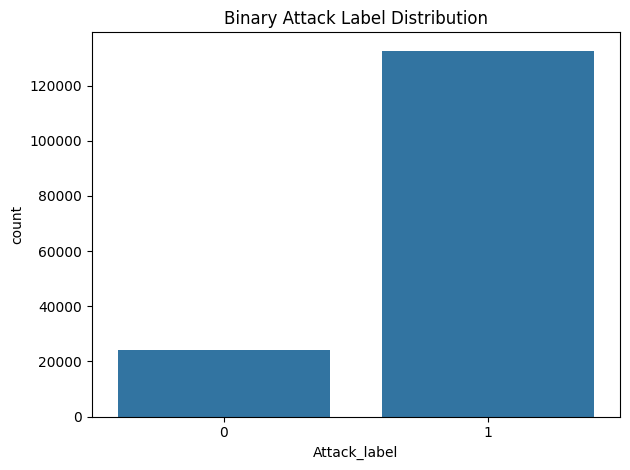

Attack_label
1    132685
0     24301
Name: count, dtype: int64


In [ ]:
# evaluate df

summarise_df(df)

print_unique_values(df)

show_target_distribution(df)


## Splitting to Training and Testing


In [130]:
# split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Attack_label'])


## Statistical Preprocessing 

In [131]:
# compile list of numerical and categorical features
# categorical if object or <= 10 unique values

categorical_features = []
numerical_features = []

for col in train_df.columns[:-1]:
    if train_df[col].dtype == 'object' or len(train_df[col].unique()) <= 10:
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


Categorical features: ['http.request.uri.query', 'http.request.method', 'http.referer', 'http.request.version', 'tcp.options', 'tcp.payload', 'tcp.srcport', 'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.msg', 'mqtt.protoname', 'mqtt.topic']
Numerical features: []


In [121]:
def preserve_and_clean(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.strip()
    return df

train_df = preserve_and_clean(train_df, categorical_features)
test_df = preserve_and_clean(test_df, categorical_features)


### Scaling


In [122]:
# scale numerical features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])


ValueError: at least one array or dtype is required

### Encoding


In [132]:
# encode categorical features
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
train_df[categorical_features] = onehot.fit_transform(train_df[categorical_features])
test_df[categorical_features] = onehot.transform(test_df[categorical_features])


ValueError: Columns must be same length as key

In [ ]:
summarise_df(train_df)


## Write to File


In [ ]:
# save into preprocessed/
# train_df.to_csv("./dataset/edge-iiotset/preprocessed/train.csv", index=False)
# test_df.to_csv("./dataset/edge-iiotset/preprocessed/test.csv", index=False)
